In [389]:
using Plots
using JLD2
using Statistics
using LinearAlgebra


In [420]:
data_mwms = load("data/surface_square_mwms_5_15_0.596_0.607_400_3_1023680.jld2")
Krange = 1 : length(collect(values(data_mwms["p_list"]))[1])
drange = data_mwms["drange"]
σrange = data_mwms["σrange"]
p_mwms_list = data_mwms["p_list"]

data_bsv = load("data/surface_square_bsv_3_23_0.596_0.607_1e7.jld2")
p_bsv_list = data_bsv["p_list"] ;
drange_bsv = data_bsv["drange"] ;

linewidth=2
linecolors = get_color_palette(:auto, plot_color(:white)) ;

In [403]:
"""
    get_p0list_sorted(p_list, drange, σrange)

Sorts the input dictionary `p_list` and reshapes it into a list of vectors, each corresponding to a fixed value of `σ` over all `d` values.
Returns a vector of vectors, where each inner vector contains sorted p0 values for a given `σ`.
"""
function get_p0list_sorted(p_list, drange, σrange)
    p0list_sorted = sort(p_list)
    p0list_sorted = collect(values(p0list_sorted))
    p0list_sorted = reshape(p0list_sorted, (length(drange), length(σrange)))
    p0list_sorted = [p0list_sorted[:,i] for i in 1:size(p0list_sorted,2)]
    return p0list_sorted
end

"""
    crossing(x1, x2, y1, y2, y3, y4)

Computes the crossing point between two lines defined by points (`x1`, `y1`), (`x2`, `y2`) and (`x1`, `y3`), (`x2`, `y4`).
Returns the x-value where the lines cross.
"""
crossing(x1, x2, y1,y2, y3,y4) = (x2/(x2-x1) * (y4-y1-y3+y2)+y1-y2) / ((y4-y1-y3+y2)/(x2-x1))

"""
    get_crossing(sorted_p0list, d_ind)

Finds the crossing point in `sorted_p0list` for a given index `d_ind` over the `σrange`.
Returns the interpolated crossing value of `σ` where the change in sign occurs between consecutive elements.
"""
function get_crossing(sorted_p0list, d_ind)
    diff = [item[d_ind] for item in sorted_p0list] - [item[d_ind+1] for item in sorted_p0list]
    ind_1st_positive = findfirst(x->x>0, diff)
    
    σ1 = σrange[ind_1st_positive-1]
    σ2 = σrange[ind_1st_positive]    
    y1 = sorted_p0list[ind_1st_positive][d_ind+1]
    y2 = sorted_p0list[ind_1st_positive][d_ind]
    y3 = sorted_p0list[ind_1st_positive-1][d_ind]
    y4 = sorted_p0list[ind_1st_positive-1][d_ind+1]    
    
    return crossing(σ1, σ2, y1, y2, y3, y4)
end

"""
    fit_zero_crossing(x, y, del)

Fits a weighted least squares line to (x, y) data, using del as the standard deviation of y.
Returns the x-value where the fitted line crosses zero and its standard error.
"""
function fit_zero_crossing(x::AbstractVector, y::AbstractVector, del::AbstractVector)
    w = 1 ./ (del .^ 2)
    X = [ones(length(x)) x]
    W = Diagonal(w)
    β = (X' * W * X) \ (X' * W * y)
    covβ = inv(X' * W * X)
    # x_cross = -β[1]/β[2]
    # Error propagation:
    dxdb = [-1/β[2], β[1]/β[2]^2]
    var_xcross = dxdb' * covβ * dxdb
    x_cross = -β[1] / β[2]
    err_x_cross = sqrt(var_xcross)
    return x_cross, err_x_cross
end

fit_zero_crossing

In [452]:
num_samples_mwms = 1023680
num_samples_bsv = 1e7
function plot_crossings(d1, d2)
    p_bsv_list_sorted = get_p0list_sorted(p_bsv_list, drange_bsv, σrange)
    d1_index_bsv = findfirst(==(d1), drange_bsv)
    crossing_bsv_d1 = get_crossing(p_bsv_list_sorted, d1_index_bsv)

    crossing_mwms_d1 = []
    g = plot(tickfontsize=12, labelfontsize=12,grid=false)
    plot!(
        subplot=2, 
        inset = bbox(0.23, 0.21, 0.44, 0.39, :bottom, :left),
        background_color = :transparent,
        legend = :bottomleft
    )
    for K in Krange
        p_mwms_list_2 = Dict(key=>val[K] for (key, val) in p_mwms_list)
        p_mwms_list_sorted = get_p0list_sorted(p_mwms_list_2, drange, σrange)

        Ks = [Krange[1], Krange[end]]
        if K ∈ Ks
            # Plotting
            for (dind, d) in enumerate(drange)
                if d ∈ [d1, d2]
                    d==d1 ? color = linecolors[1] : color = linecolors[2]

                    if K==Ks[1]
                        linestyle = :dash
                        label = "d=$d, K=$K"
                    else
                        linestyle = :solid
                        label = "d=$d, all explored MWMs for K=400"
                    end
                    y_mean_0 = [item[dind] for item in p_mwms_list_sorted]
                    y_mean = y_mean_0 .^ 2 
                    yerr = 2 .* y_mean_0 .* 2 .* sqrt.(y_mean_0 .* (1 .- y_mean_0) ./ num_samples_mwms)
                    # println("d, K=$d, $K ", y_mean)
                    # println("d, K=$d, $K ", yerr)
                    plot!(σrange, y_mean, marker=:circle, label=label, color=color, linewidth=linewidth, linestyle=linestyle, yerr=yerr)
                    
                    if K==Ks[1]
                        ind1 = 1
                        ind2 = length(σrange)
                        inds = ind1:ind2
                        d_index_bsv = findfirst(==(d), drange_bsv)
                        y_mean_0 = [item[d_index_bsv] for item in p_bsv_list_sorted]
                        y_mean = y_mean_0 .^ 2 
                        yerr = 2 .* y_mean_0 .* 2 .* sqrt.(y_mean_0 .* (1 .- y_mean_0) ./ num_samples_bsv)
                        # println("BSV, d, K=$d, $K ", y_mean)
                        # println("BSV, d, K=$d, $K ", yerr)
                        # println()
                        plot!(σrange[inds], y_mean[inds], subplot=2, marker=:square, label="d=$d, optimal", color=color, linewidth=linewidth, linestyle=linestyle, yerr=yerr[inds])
                    end
                end
            end

            plot!(xlabel="σ", ylabel="Fidelity")
        end

        # Find crossing points
        d1_index = findfirst(==(d1), drange)
        crossing_d1 = get_crossing(p_mwms_list_sorted, d1_index)
        push!(crossing_mwms_d1, crossing_d1)
    end

    plot!(
        subplot=2, 
        tickfontsize=12,
        labelfontsize=12,
        grid=false,
        ylabel="",
        xlabel="",
        # ylim=(0.838^2, 0.879^2),
        xticks=[σrange[1], σrange[5], σrange[9], σrange[end]],
    )
    # annotate!(subplot=2, 0.5975, 0.88, "Fidelity")
    # annotate!(subplot=2, 0.608, 0.84, "σ")

    display(g)
    return crossing_mwms_d1, crossing_bsv_d1, g
end

plot_crossings (generic function with 1 method)

# Fig a

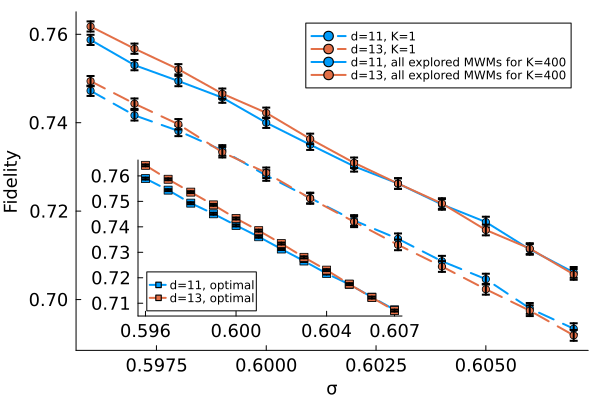

In [453]:
crossing_mwms_d1, crossing_bsv_d1, _ = plot_crossings(11, 13) ;

In [454]:
println(crossing_mwms_d1)

Any[0.5987865961199292, 0.5987579169598874, 0.5986088117489987, 0.5985035211267605, 0.5985638945233266, 0.5985135363790187, 0.5985303152789005, 0.5984484272128748, 0.598502027027027, 0.5985202593192868, 0.5985576208178437, 0.5985823569951758, 0.5985930313588851, 0.5985591322603219, 0.598557037037037, 0.5985374912403645, 0.5985470085470084, 0.5985208175624526, 0.5985513673318549, 0.5985877520537713, 0.5986554307116105, 0.5986776165011459, 0.5987103610675039, 0.5987096505823627, 0.5987198027937551, 0.5986917978458989, 0.5987105030891438, 0.598716049382716, 0.5987472803347281, 0.5988024263431543, 0.5987850241545895, 0.5988186666666665, 0.5987796901893288, 0.5988032094594593, 0.5988157467532467, 0.5987921207041074, 0.598836717428088, 0.5988249551166963, 0.5988372469635628, 0.5988421940928271, 0.5987985436893204, 0.5987766348273328, 0.5987958397534667, 0.5988296000000001, 0.5988411811652034, 0.5988022304832714, 0.5988540268456376, 0.5988115597783057, 0.5987920000000001, 0.5988108320251176, 

In [455]:
println(crossing_bsv_d1)

0.6053437892095358


In [456]:
savefig("plots/fig_threshold_surf_sq_a.pdf")

"/Users/maolinml/Documents/Research/LatticeAlgorithms.jl_github/LatticeAlgorithms.jl/examples/papers/Approximate_maximum_likelihood_decoding_with_K_minimum_weight_matchings/plots/fig_threshold_surf_sq_a.pdf"

# Fig b (13,15)

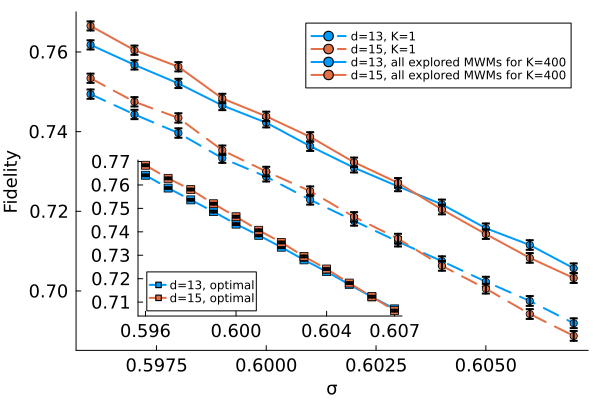

In [457]:
crossing_mwms_d1, crossing_bsv_d1, _ = plot_crossings(13, 15) ;

In [458]:
println(crossing_mwms_d1)

Any[0.6033918575063615, 0.6033153488372093, 0.6030619047619047, 0.6031260744985673, 0.6030315789473684, 0.6030837209302324, 0.6022622950819668, 0.6028195488721801, 0.6022052631578946, 0.6027759562841529, 0.6026588628762545, 0.602124513618677, 0.6018755074424899, 0.6017932489451476, 0.6019118497109828, 0.6026055555555556, 0.6019078751857354, 0.6027424242424242, 0.6019191655801822, 0.6028933333333343, 0.6023359999999992, 0.6030104244229336, 0.6024016736401672, 0.6023041474654379, 0.6023515358361777, 0.6023803278688521, 0.6021417322834645, 0.6021914893617025, 0.6022787610619469, 0.6023443526170803, 0.6024458598726113, 0.6024778761061946, 0.6024873096446699, 0.6024852071005917, 0.6025124153498872, 0.6024483516483514, 0.6023229665071768, 0.6024225663716815, 0.6024308035714285, 0.602412621359223, 0.6024879649890591, 0.6025035629453681, 0.6025181236673772, 0.6026845794392525, 0.6025665322580643, 0.602606435643564, 0.6025940298507462, 0.6026735537190085, 0.602496710526316, 0.6025475409836064, 

In [459]:
println(crossing_bsv_d1)

0.6060981753272511


In [460]:
savefig("plots/fig_threshold_surf_sq_b.pdf")

"/Users/maolinml/Documents/Research/LatticeAlgorithms.jl_github/LatticeAlgorithms.jl/examples/papers/Approximate_maximum_likelihood_decoding_with_K_minimum_weight_matchings/plots/fig_threshold_surf_sq_b.pdf"